In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import pickle

In [107]:
df_gold = pd.read_csv("../dataset/gold_data_cleaned.csv")
df_gold["Date"] = pd.to_datetime(df_gold["Date"])
df_gold.set_index("Date", inplace=True)

In [108]:
# Hapus kolom yang tidak relevan
df_gold.drop(columns=["Unnamed: 0", "Ticker"], inplace=True, errors="ignore")

# Cek missing values
df_gold.dropna(inplace=True)

# Pilih fitur yang digunakan untuk training
selected_features = [
    "Open_1h", "High_1h", "Low_1h", "Close_1h", "Volume_1h", "Return_1h",
    "Open_1d", "High_1d", "Low_1d", "Close_1d", "Volume_1d", "Return_1d"
]
data = df_gold[selected_features]

# Normalisasi data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Bentuk data time series
lookback = 30  # Gunakan 30 langkah sebelumnya
X, y = [], []
for i in range(lookback, len(data_scaled)):
    X.append(data_scaled[i - lookback:i])     # Input: 30 hari sebelumnya
    y.append(data_scaled[i])                  # Target: semua 12 fitur
X, y = np.array(X), np.array(y)

# Pisahkan menjadi training dan testing set
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Tampilkan bentuk dataset
print("Shape X_train:", X_train.shape)
print("Shape X_test:", X_test.shape)

# --- Hitung Jumlah Fitur Output ---
num_output_features = y_train.shape[1]
print(f"Jumlah fitur output: {num_output_features}")

Shape X_train: (7468, 30, 12)
Shape X_test: (1867, 30, 12)
Jumlah fitur output: 12


In [109]:
# Buat optimizer dengan clipnorm agar gradien tidak meledak
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)

# Bangun model LSTM
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(64),
    Dense(32, activation='relu', kernel_regularizer='l2'),
    Dense(num_output_features)
])

c:\Users\ejaad\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [110]:
# Compile model
model.compile(optimizer=optimizer, loss="mean_squared_error", metrics=['mae', 'mape'])

# Tampilkan ringkasan model
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                  │ (None, 30, 64)         │        19,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 12)             │           396 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,212 (215.67 KB)

 Trainable params: 55,212 (215.67 KB)

 Non-trainable params: 0 (0.00 B)

In [111]:

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)

# Training
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[TerminateOnNaN(), early_stop, reduce_lr],
    verbose=1
)

# Evaluasi
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


Epoch 1/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 31s 218ms/step - loss: 0.8725 - mae: 0.5094 - mape: 96.9305 - val_loss: 0.9182 - val_mae: 0.6056 - val_mape: 56.9431 - learning_rate: 0.0010
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 12s 193ms/step - loss: 0.4636 - mae: 0.2636 - mape: 67.0432 - val_loss: 0.6194 - val_mae: 0.4800 - val_mape: 45.8199 - learning_rate: 0.0010
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - loss: 0.3266 - mae: 0.2187 - mape: 58.8426 - val_loss: 0.4500 - val_mae: 0.4270 - val_mape: 47.3590 - learning_rate: 0.0010
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - loss: 0.2419 - mae: 0.1988 - mape: 62.1047 - val_loss: 0.3691 - val_mae: 0.3972 - val_mape: 55.0513 - learning_rate: 0.0010
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 243ms/step - loss: 0.1981 - mae: 0.1854 - mape: 79.3898 - val_loss: 0.3404 - val_mae: 0.3959 - val_mape: 58.5725 - learning_rate: 0.0010
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 0.1794 - mae: 0.1821 - mape: 104.0178 - v

In [112]:
# Prediksi
y_pred = model.predict(X_test)

# Inverse scaling
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)


print("Cek pred NaN setelah predict test set:", np.isnan(y_pred).any())

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Cek pred NaN setelah predict test set: False


In [113]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Ambil hanya kolom Close_1h dari hasil prediksi dan target
target_index = 10  # Close_1h di indeks ke-3
y_test_target = y_test[:, target_index].reshape(-1, 1)
y_pred_target = y_pred[:, target_index].reshape(-1, 1)

actual = y_test_inv[:, target_index]
predicted = y_pred_inv[:, target_index]

mse = mean_squared_error(actual, predicted)
mae = mean_absolute_error(actual, predicted)
mape = np.mean(np.abs((actual - predicted) / actual)) * 100
r2 = r2_score(actual, predicted)

print(f"📊 Model Evaluation:")
print(f"🔸 Mean Squared Error (MSE): {mse:.6f}")
print(f"🔸 Mean Absolute Error (MAE): {mae:.6f}")
print(f"🔸 Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"🔸 R² Score: {r2:.4f}")
print(f"✅ Model Accuracy (based on MAPE): {100 - mape:.2f}%")



📊 Model Evaluation:
🔸 Mean Squared Error (MSE): 19433.734338
🔸 Mean Absolute Error (MAE): 97.966220
🔸 Mean Absolute Percentage Error (MAPE): 27.22%
🔸 R² Score: 0.8444
✅ Model Accuracy (based on MAPE): 72.78%


In [114]:
# Pastikan menyimpan nama kolom sebelum melakukan scaling
feature_names = df_gold.columns  

# Tampilkan nama fitur berdasarkan indeks
for i, name in enumerate(feature_names):
    print(f"Index-{i}: {name}")

Index-0: Open_1h
Index-1: High_1h
Index-2: Low_1h
Index-3: Close_1h
Index-4: Volume_1h
Index-5: Return_1h
Index-6: Ticker_1h
Index-7: Open_1d
Index-8: High_1d
Index-9: Low_1d
Index-10: Close_1d
Index-11: Volume_1d
Index-12: Return_1d
Index-13: Ticker_1d


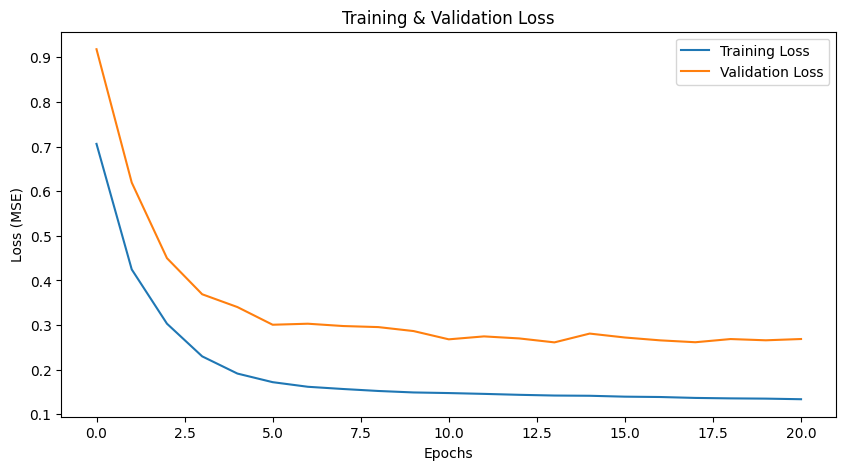

In [115]:
# Plot loss function
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()


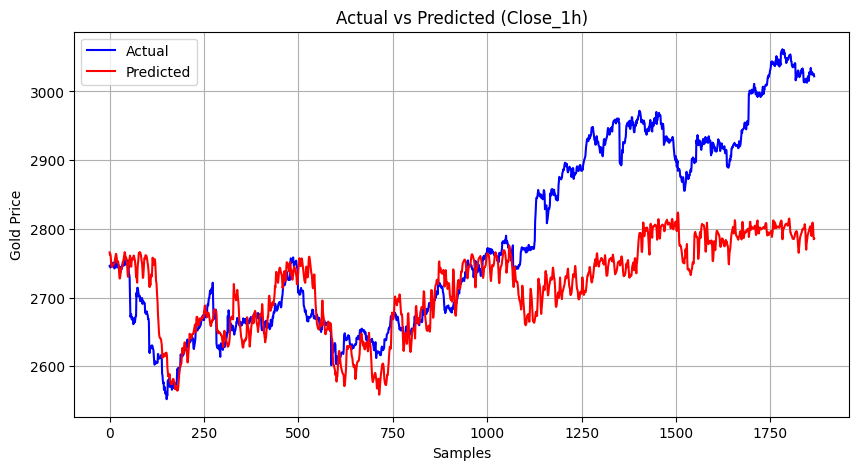

In [116]:
# Ambil indeks fitur Close_1h
target_index = selected_features.index("Close_1h")

# Plot prediksi vs aktual
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv[:, target_index], label='Actual', color='blue')
plt.plot(y_pred_inv[:, target_index], label='Predicted', color='red')
plt.title("Actual vs Predicted (Close_1h)")
plt.xlabel("Samples")
plt.ylabel("Gold Price")
plt.legend()
plt.grid(True)
plt.show()



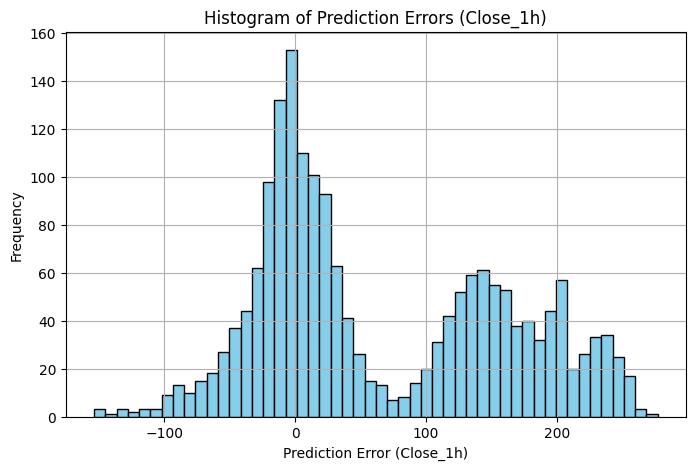

In [117]:
# Ambil indeks fitur Close_1h
target_index = selected_features.index("Close_1h")

# Ambil hanya kolom Close_1h dari hasil inverse
actual = y_test_inv[:, target_index]
predicted = y_pred_inv[:, target_index]

# Hitung error
error = actual - predicted

# Plot histogram error
plt.figure(figsize=(8, 5))
plt.hist(error, bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Prediction Error (Close_1h)")
plt.ylabel("Frequency")
plt.title("Histogram of Prediction Errors (Close_1h)")
plt.grid(True)
plt.show()


In [118]:
# Simpan model ke .h5 (karena Keras tidak bisa dipickle langsung)
model.save("model_gold.h5")

In [119]:
# Inisialisasi dan fit scaler untuk seluruh fitur
scaler_all = StandardScaler()
scaler_all.fit(data)  # data = seluruh dataset fitur sebelum modeling

# Simpan scaler ke pickle
with open("scaler_gold.pkl", "wb") as f:
    pickle.dump(scaler_all, f)


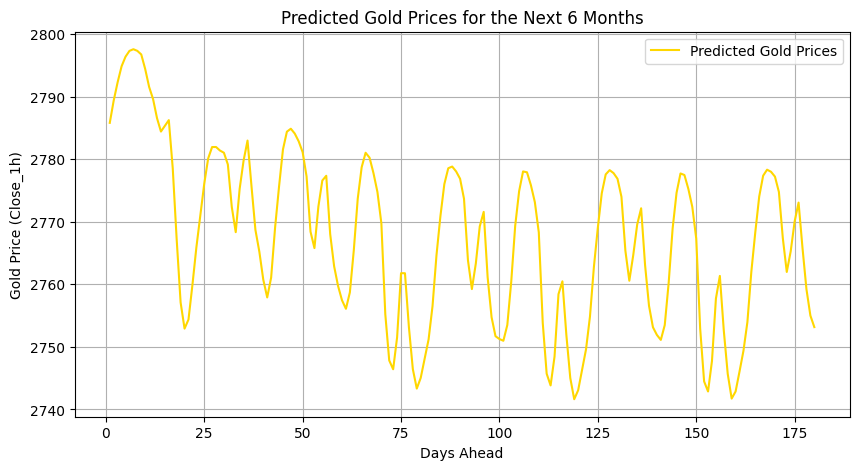

In [ ]:

# Load model dan scaler
model = load_model("model_gold.h5")
with open("scaler_gold.pkl", "rb") as f:
    scaler_all = pickle.load(f)

# Fungsi prediksi harga masa depan
def predict_future_price(model, X_test, scaler_all, future_days=180, close_index=3):
    last_sequence = X_test[-1]
    predictions_close = []

    for _ in range(future_days):  
        pred_scaled = model.predict(last_sequence.reshape(1, 30, 12), verbose=0)  # Output shape: (1, 12)
        pred_original = scaler_all.inverse_transform(pred_scaled)  # Inverse semua fitur

        predictions_close.append(pred_original[0][close_index])  # Ambil kolom Close_1h 

        # Update last_sequence dengan prediksi yang sudah discale 
        last_sequence = np.roll(last_sequence, -1, axis=0)
        last_sequence[-1] = pred_scaled[0]  # Tambahkan semua fitur hasil prediksi

    return np.array(predictions_close)

# Prediksi 6 bulan ke depan
future_days = 180
future_prices_gold = predict_future_price(model, X_test, scaler_all, future_days)

# Plot hasil prediksi
plt.figure(figsize=(10, 5))
plt.plot(range(1, future_days + 1), future_prices_gold, label="Predicted Gold Prices", color='gold')
plt.xlabel("Days Ahead")
plt.ylabel("Gold Price (Close_1h)")
plt.title("Predicted Gold Prices for the Next 6 Months")
plt.legend()
plt.grid()
plt.show()


In [121]:

import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import MinMaxScaler

# Load dataset emas
df = pd.read_csv("../dataset/gold_data_cleaned.csv")  

# Pilih fitur yang digunakan untuk training
selected_features = [
    "Open_1h", "High_1h", "Low_1h", "Close_1h", "Volume_1h", "Return_1h",
    "Open_1d", "High_1d", "Low_1d", "Close_1d", "Volume_1d", "Return_1d"
]

data = df[selected_features]

# Load scaler yang sama saat training
with open("scaler_gold.pkl", "rb") as f:
    scaler = pickle.load(f)

features = [ 
    "Open_1h", "High_1h", "Low_1h", "Close_1h", "Volume_1h", "Return_1h",
    "Open_1d", "High_1d", "Low_1d", "Close_1d", "Volume_1d", "Return_1d"]  
scaler = MinMaxScaler()
scaler.fit(data[features])

scaled_data = scaler.transform(data[features])
last_sequence = scaled_data[-30:] 

# Simpan scaler dan last_sequence
with open("scaler_gold.pkl", "wb") as f:
    pickle.dump(scaler, f)
np.save("last_sequence_gold.npy", last_sequence)

# Pastikan bentuknya (30, 12)
print("Shape last_sequence:", last_sequence.shape)



Shape last_sequence: (30, 12)


In [122]:
input_scaled = last_sequence.reshape(1, 30, 12)
pred = model.predict(input_scaled, verbose=0).reshape(12,)
print("Prediksi mentah (tanpa inverse):", pred)
print("Mengandung NaN?", np.isnan(pred).any())


Prediksi mentah (tanpa inverse): [-0.03562435  0.02596757 -0.03813386  0.00170205  0.04747928  0.01966948
  0.07340132 -0.06453122 -0.02513932  0.0164642  -0.00967451 -0.00306619]
Mengandung NaN? False
